In [2]:
import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt
import plotly.express as px

from plotly import graph_objects as go

import sys
sys.path.append("..")

flatten = lambda t: [item for sublist in t for item in sublist]

In [3]:
comment_df = pd.read_excel("..\data\cleaned_swed_lemma.xlsx")
comment_df.drop(index = [9, 1555, 2474, 2483, 4346, 7212], inplace = True)

#remove short words
comment_df.text = comment_df.text.map(lambda line: " ".join( [word for word in line.split(" ") if (len(word) > 3 or word == "mzp")] ))

In [4]:
comment_df

,Unnamed: 0,Unnamed: 0.1,comment_id,text,author,upvotes,timestamp,post_id,lens
0,0,5,hgikv58,újranezem Edit elmond vélemény,MarkMew,3,1634150485,q7hft0,14
1,1,6,hgilh98,több hallgat dobrev klárából érez iqval rendel...,just_szabi,3,1634150728,q7hft0,19
2,2,7,hgiledw,tetszik mzp korrupcióellenes javaslat válaszol...,Buntisteve,2,1634150698,q7hft0,47
3,3,8,hgilif7,mzp valós dolog állít kimért óvatos költekezik...,Atekboss,2,1634150741,q7hft0,41
4,4,9,hgik5u8,feszült vita hajtépős ideges dobrev lenézően p...,ChronosHD,3,1634150198,q7hft0,30
...,...,...,...,...,...,...,...,...,...
8590,8590,16518,hb5zin0,sajtó jelenik híre sosem állított megüt bevert...,hadhazyakos,89,1630486947,pfpjma,65
8591,8591,16519,hb66gf4,protip life bírósági ítéleteket maga egész ért...,orbanygyiktor,7,1630492763,pfpjma,24
8592,8592,16520,hb5zm9h,hangfelvételen dulakodás hamisítvány szegény S...,BitPork,10,1630487037,pfpjma,12
8593,8593,16521,hb643ll,schiffer kavar szar rendes „látlelet” garázdas...,dickblaha,13,1630490921,pfpjma,85


# TF-IDF

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
c = CountVectorizer()

In [4]:
term_doc = pd.DataFrame(c.fit_transform(comment_df.text.astype('U')).toarray())
#term_doc = pd.get_dummies(comment_df.text)

term_frequency = term_doc.divide( term_doc.sum(axis="columns"), axis="rows")
term_frequency.sum(axis="columns")

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
8584    1.0
8585    1.0
8586    1.0
8587    1.0
8588    1.0
Length: 8589, dtype: float64

In [5]:
# idf number of documents / number of documents containing the word
temp = np.zeros(len(term_doc.columns))

for i in range(len(temp)):
    temp[i] = sum(term_doc.iloc[:,i].map(lambda x: 1 if x > 0 else 0))
    
idf = np.log(len(term_doc) / temp)

In [6]:
tf_idf = term_frequency * idf


In [7]:
#LSA method: making SVD with the tf_idf, then taking the first n most significant vectors to score the documents

from sklearn.decomposition import TruncatedSVD
n_comp = 7
svd = TruncatedSVD(n_components = n_comp)
lsa = svd.fit_transform(tf_idf)

In [8]:
topic_encoded_df = pd.DataFrame(lsa, index = comment_df.index,
                                columns = [f"topic{i}" for i in range(n_comp)])
topic_encoded_df["text"] = comment_df.text

In [9]:
encoding_matrix = pd.DataFrame(svd.components_, 
                               index = [f"topic{i}" for i in range(n_comp)], 
                               columns = c.get_feature_names())


C:\Users\balin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [10]:
top_by_topic = pd.DataFrame()
for col in encoding_matrix.index:
    topic_temp_df = pd.DataFrame(encoding_matrix.T.sort_values(col, axis = "rows", ascending = False, 
                                                               key = np.abs)[col][:15]).reset_index()
    topic_temp_df.columns = [col, col+"_value"]
    top_by_topic = pd.concat([top_by_topic, topic_temp_df.round(2)], axis = 1)

In [11]:
top_by_topic.to_excel(r"..\data\top_by_topic_LSI_lemma.xlsx")
top_by_topic

,topic0,topic0_value,topic1,topic1_value,topic2,topic2_value,topic3,topic3_value,topic4,topic4_value,topic5,topic5_value,topic6,topic6_value
0,mzp,0.24,átlépted,0.30,gyurcsány,0.60,poll,0.73,dobrev,0.49,szavaz,0.60,dobrev,-0.40
1,szavaz,0.23,korlátot,0.30,stop,0.41,peter,0.56,mzp,0.33,online,0.26,tóth,0.39
2,tud,0.21,végrehajt,0.29,karácsony,0.31,tamad,0.15,gyurcsány,-0.32,stop,0.21,csaba,0.38
3,dobrev,0.21,poszt,0.29,szavaz,-0.23,cimbe,0.15,stop,-0.23,csaba,-0.16,karácsony,0.31
4,fog,0.20,napi,0.29,online,-0.12,tegyel,0.14,karácsony,0.20,tóth,-0.16,gyurcsány,-0.22
5,karácsony,0.19,próbál,0.27,mzp,0.11,ujra,0.13,tud,-0.17,fog,0.15,mzp,0.19
6,fidesz,0.18,intézkedés,0.27,tud,-0.11,reportol,0.12,klára,0.16,tud,-0.15,fog,0.18
7,gyurcsány,0.16,automatikus,0.26,dobrev,0.11,vegzetes,0.08,nyer,0.16,orbán,-0.14,klára,-0.17
8,mond,0.14,töröltük,0.26,átlépted,0.10,lecsap,0.08,ember,-0.15,dobrevre,0.13,orbán,-0.16
9,nyer,0.14,posztodat,0.26,korlátot,0.10,figyelmes,0.08,fog,0.11,mzp,-0.12,stop,0.14


In [12]:
#health check: check which elements are none
comment_df.reset_index().drop(columns = ["index"])[term_frequency.isna().T.any()].index

Int64Index([], dtype='int64')

(1.0, 60.0)

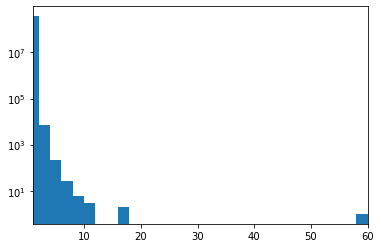

In [13]:
#health check
plt.hist(c.fit_transform(comment_df.text).toarray().flatten(), bins = 30)
plt.yscale("log")
plt.xlim(1,60)

# SKLearn pipeline

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

n_comp = 7
svd2 = TruncatedSVD(n_components = n_comp)

tf_idf_sk = TfidfVectorizer(norm="l1")
X = tf_idf_sk.fit_transform(comment_df.text)

lsa2 = svd2.fit_transform(X)

topic_encoded_df = pd.DataFrame(lsa2, columns = [f"topic{i}" for i in range(n_comp)])

encoding_matrix2 = pd.DataFrame(svd2.components_, 
                               index = [f"topic{i}" for i in range(n_comp)], 
                               columns = tf_idf_sk.get_feature_names())

top_by_topic2 = pd.DataFrame()
for col in encoding_matrix2.index:
    topic_temp_df2 = pd.DataFrame(encoding_matrix2.T.sort_values(col, axis = "rows", ascending = False, 
                                                               key = np.abs)[col][:15]).reset_index()
    topic_temp_df2.columns = [col, col+"_value"]
    top_by_topic2 = pd.concat([top_by_topic2, topic_temp_df2], axis = 1)

C:\Users\balin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [21]:
top_by_topic2

,topic0,topic0_value,topic1,topic1_value,topic2,topic2_value,topic3,topic3_value,topic4,topic4_value,topic5,topic5_value,topic6,topic6_value
0,mzp,0.392225,gyurcsány,0.800659,dobrev,0.799451,mzp,0.750534,szavaz,0.576887,karácsony,-0.397897,karácsony,-0.566375
1,dobrev,0.373108,szavaz,-0.384690,szavaz,-0.327973,gyurcsány,-0.295526,fidesz,-0.383281,poszt,0.258959,mzp,0.309921
2,szavaz,0.300175,karácsony,0.236857,gyurcsány,-0.161786,dobrev,-0.286262,karácsony,0.264244,átlépted,0.249721,gyurcsány,0.239752
3,karácsony,0.266180,stop,0.168913,ember,-0.145791,szavaz,-0.278446,mond,-0.231738,korlátot,0.249083,fidesz,0.213412
4,gyurcsány,0.244576,dobrev,-0.094170,akar,-0.145299,karácsony,0.186268,ember,-0.218985,próbál,0.248959,szavaz,0.173731
5,fidesz,0.210096,megy,-0.091242,klára,0.140007,hisz,0.130747,orbán,-0.186421,automatikus,0.246296,stop,-0.153352
6,nyer,0.186795,online,-0.086519,fidesz,-0.098576,fidesz,-0.119363,akar,-0.132723,napi,0.244810,márkizay,-0.138401
7,mond,0.156493,fidesz,-0.078876,megy,-0.092094,ember,-0.079957,annyi,-0.126883,végrehajt,0.243972,automatikus,-0.138022
8,orbán,0.141057,akar,-0.069409,online,-0.091438,akar,-0.072005,gyurcsány,0.120606,töröltük,0.238155,poszt,-0.132609
9,ember,0.132475,dobrevre,-0.056444,nyer,0.072289,visszalép,0.069678,magyar,-0.105640,posztodat,0.238155,korlátot,-0.131955
